# Root Shape and Size Analysis

This is a full workflow that shows methods for analyzing the shape and morphology of roots. These methods should work for similar photos.

# Section 1: Importing libraries and image

In [1]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [2]:
# Import libraries
from plantcv import plantcv as pcv
import numpy as np
import cv2

## Input variables
The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [3]:
class options:
    def __init__(self):
        self.image = "./img/root_image.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "root_analysis_results.txt"
        self.outdir = "."

In [4]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 2
pcv.params.text_thickness = 2
pcv.params.line_thickness = 10

## Read the input image

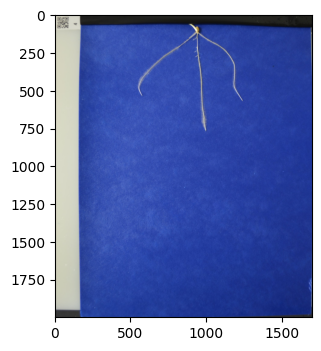

In [5]:
# Inputs:
#   filename = Image file to be read in 
#   mode     = How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

# Section 2: Isolating plant, making binary mask, getting object(s)¶
* Requires successful import of image
* See Tools for Thresholding Plant Data for a full list of functions that can be used to create a binary mask

## Crop image

Not necessary, but sometimes when plant material is only is one portion of the image, it can be easier to see the quality of the binary threshold when it is cropped to the plant material.

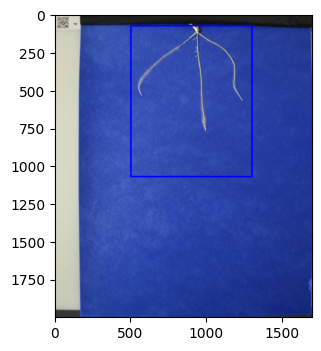

In [6]:
# Inputs: 
#   img = image
#   x   = leftmost x coordinate 
#   y   = topmost y coordinate
#   h   = height of cropped image
#   w   = width of cropped image
img_cropped = pcv.crop(img = img, x = 500, y = 70, h = 1000, w = 800)

## Visualize colorspaces
The visualization tool converts the color image into HSV and LAB colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

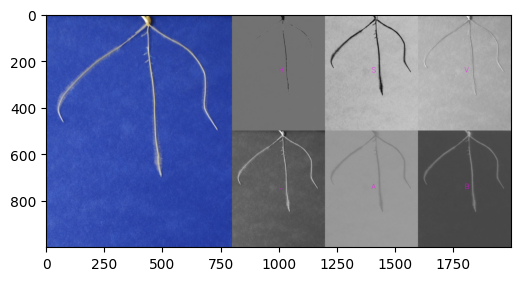

In [7]:
# Inputs:
#   rbg_img = original image
#   original_img = whether to include the original RGB images in the display: True (default) or False
colorspaces = pcv.visualize.colorspaces(rgb_img=img_cropped)

## Convert the color image to grayscale
Converts the input color image into the LAB colorspace and returns the B (blue-yellow) channel as a grayscale image.

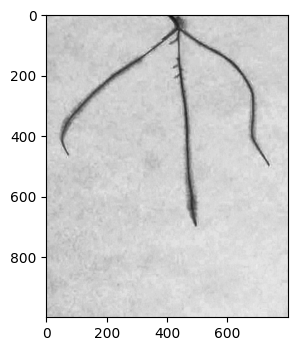

In [8]:
# Inputs:
#   rbg_img = original image
#   channel = desired colorspace ('l', 'a', or 'b')
a = pcv.rgb2gray_lab(rgb_img = img_cropped, channel = 'a')

## Visualize the distribution of grayscale values
A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the selection of a threshold value.

For this image, the large peak between 150-158 are from the lighter background pixels. The smaller peaks that represent plant material are around 120-140, so a threshold between 140-150 should best distinguish the roots from the background data.

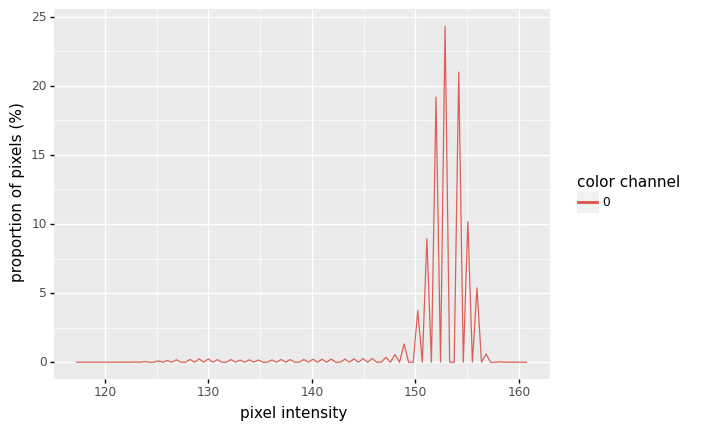

In [9]:
# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=a)

## Threshold the grayscale image
Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Using the histogram above, a threshold point between 140-150 will segment the plant and background peaks. Because the root has darker pixels in this image, use object_type="dark" to do a traditional threshold.

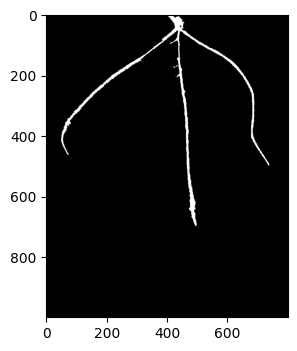

In [10]:
# Inputs:
#   gray_img    = black and white image created from selected colorspace
#   threshold   = cutoff pixel intensity value (all pixels below value will become black, all above will become white)
#   max_value   = maximum pixel value
#   object_type = 'dark' or 'light' depending on if seeds are darker or lighter than background
a_thresh = pcv.threshold.binary(gray_img=a, threshold=135, max_value=255, object_type='dark')
#                                                      ^                                 ^
#                                                      |                                 |
#                                              change this value                  change this value

## Clean up the binary mask 
Structures that will become skeletonized are sensitive to any dark noise, breaks in the object, holes, or closed loops. Thickening and filling in holes will usually help to make the morphological functions more robust across datasets.  

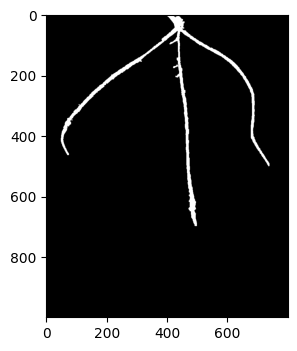

In [23]:
dilated = pcv.dilate(gray_img=a_thresh, ksize=3, i=1)

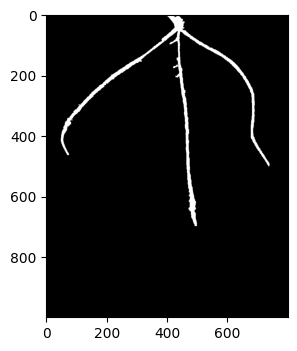

In [24]:
filled_mask = pcv.fill_holes(bin_img=dilated)

# Section 3: Finding objects and analyzing
* Requires completed binary mask

## Identify objects within image
From the binary mask, we can identify the object (plant) within the image, which can then be used later for analyses.

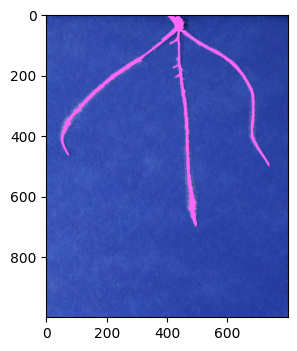

In [25]:
# Inputs:
#   img  = rgb image
#   mask = binary mask
obj, obj_hierarchy = pcv.find_objects(img=img_cropped, mask=filled_mask)

## Identify objects within a region of interest (ROI)
To eventually combine all of the objects into a singular object that identifies the plant, we need to identify a region of interest (ROI) which will either fully encapsulate or overlap with plant material. This way, if objects are identified due to "salt" noise or other background elements, they will be filtered out. In this case, a rectangular ROI that partially overlaps with the plant object can be used to filter out some of the excess noise around the plant.

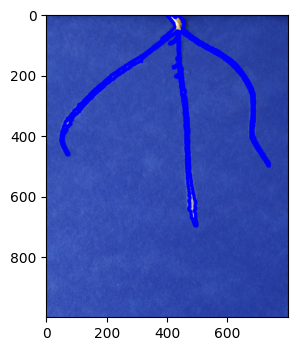

In [26]:
# Inputs:
#   img     = image
#   bin_img = binary mask for image
roi, roi_hierarchy = pcv.roi.from_binary_image(img=img_cropped, bin_img=filled_mask)

## Filter out objects that don't overlap with the ROI
Any objects that do not overlap with the ROI will be filtered out, leaving only objects that identify plant material.

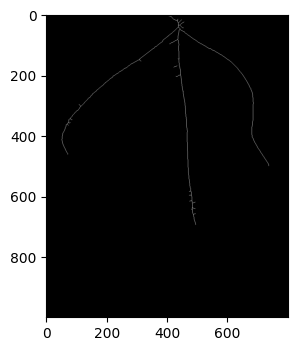

In [27]:
skeleton = pcv.morphology.skeletonize(mask=filled_mask)

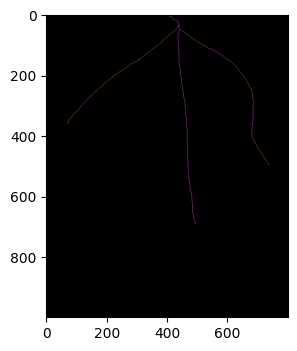

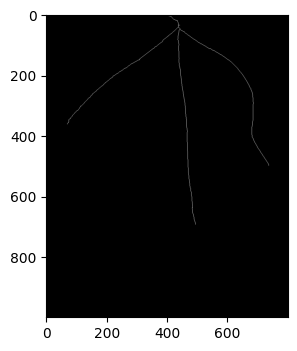

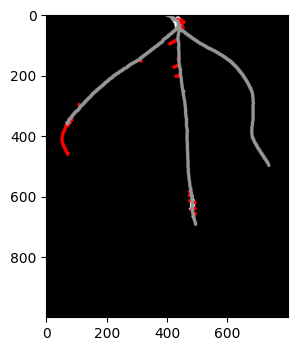

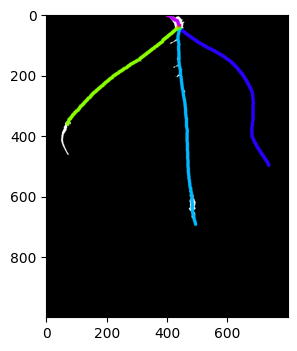

In [28]:
# Prune the skeleton  
# Generally, skeletonized images will have barbs (this image is particularly ideal, 
# that's why it's the example image in the tutorial!), 
# representing the width, that need to get pruned off. 

# Inputs:
#   skel_img = Skeletonized image
#   size     = Size to get pruned off each branch
#   mask     = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
img1, seg_img, edge_objects = pcv.morphology.prune(skel_img=skeleton, size=400, mask=a_thresh)

## Measure relative root length

By counting the number of white pixels in the skeletonized image of the root system, we can get a relative amount of root within an image that can be compared to other root images analyzed in the same way. The OpenCV function countNonZero will identify and count non-zero pixels (white).

In [29]:
# Inputs:
#   src = single-channel array (gray image in this case)
root_count = cv2.countNonZero(img1)

## Fill in segments

Fill in image segments and store out area data to output.

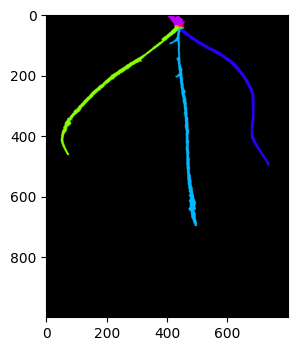

In [30]:
# Inputs:
#   mask    = Binary image, single channel, object = 1 and background = 0
#   objects = List of contours
#   label   = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

filled_img = pcv.morphology.fill_segments(mask=filled_mask, objects=edge_objects, label="default")

## Measure segment path length

Calculate geodesic distance of segments.

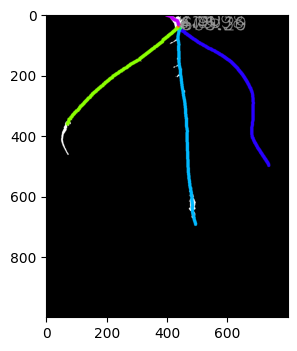

In [31]:
segment_path = pcv.morphology.segment_path_length(segmented_img=seg_img, objects=edge_objects)

## Combine objects

Objects kept after filtering out those not included in the ROI may still be multiple overlapping or layered objects, rather than just one. We need to combine objects so that one object, encapsulating the entire plant, can be passed to the image analysis function.

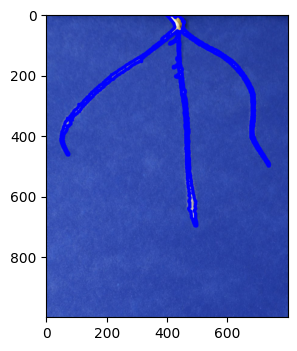

In [32]:
# Inputs:
#   img                = image
#   contours           = filtered plant contours from the roi_objects function
#   filtered_hierarchy = filtered plant contour hierarchy from the roi_objects function
plant_contour, plant_mask = pcv.object_composition(img=img_cropped, contours=obj, hierarchy=obj_hierarchy)

## Analyze plant shape

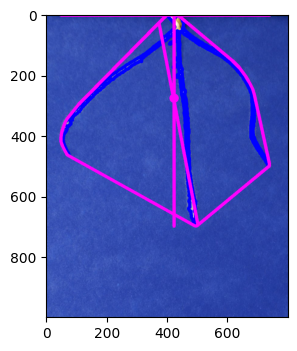

In [33]:
# Inputs:
#   img   = RGB or grayscale image data 
#   obj   = Single or grouped contour object
#   mask  = Binary image mask to use as mask for moments analysis  
#   label = Optional label parameter, modifies the variable name of observations recorded   
shape_img = pcv.analyze_object(img=img_cropped, obj=plant_contour, mask=plant_mask, label="default")

## Save results
The save results function will take the measurements stored when running any PlantCV analysis functions, format, and print an output text file for data analysis. The Outputs class in this example will store: 'segment_area', 'segment_path_length' from the morphology functions. Additionally, 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', and 'ellipse_eccentricity' are stored from the anayze_object function.

In [20]:
# Inputs:
#   filename  = filename for saving results
#   outformat = output file format: "json" (default) hierarchical format or "csv" tabular format
pcv.outputs.save_results(filename=args.result)